In [1]:
from metrics import get_discretized_tv_for_image_density
from density import continuous_energy_from_image, prepare_image, sample_from_image_density

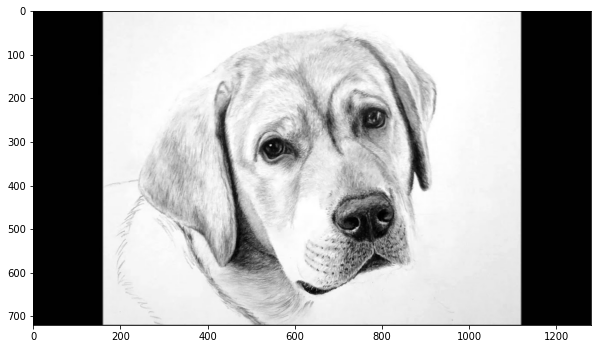

In [54]:
import matplotlib.image
import matplotlib.pyplot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams, ticker, cm
from matplotlib import collections as mc
import numpy as onp 
rcParams['animation.html'] = 'jshtml'  # Makes the default animation an interactive video
rcParams['animation.embed_limit'] = 2**128  # Allow bigger animations

img = matplotlib.image.imread('./sampling/data/labrador.jpg')

# plot and visualize
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
matplotlib.pyplot.show()

In [27]:
img.shape

(720, 1280, 3)

In [14]:
import jax

density, energy = prepare_image(
    img, crop=(10, 710, 240, 940), white_cutoff=225, gauss_sigma=3, background=0.01
)

x_max, y_max = density.shape
xp = jax.numpy.arange(x_max)
yp = jax.numpy.arange(y_max)
zp = jax.numpy.array(density)

# You may use fill value to enforce some boundary conditions or some other way to enforce boundary conditions
energy_fn = lambda coord: continuous_energy_from_image(coord, xp, yp, zp, fill_value=0)
energy_fn_grad = jax.grad(energy_fn)

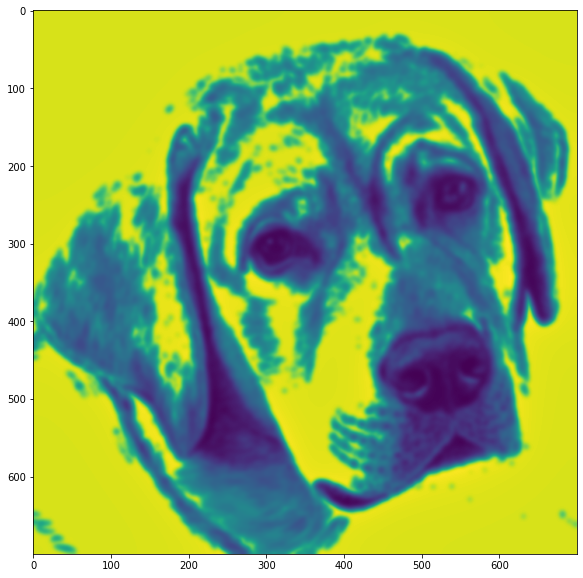

In [15]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(energy)
matplotlib.pyplot.show()

In [18]:
import jax.numpy as np
import jax
from jax import random

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

def hamiltonian_monte_carlo(x0, f, k, epsilon):
    """Run HMC for k steps, with step size epsilon"""
    v = onp.random.randn(*x0.shape)  # Not the correct way to get randoms in JAX
    g = jax.grad(f)  # Gradient of energy function
    x = x0  # save the original state, in case we reject the update
    for i in range(k):
        v = v - 0.5 * epsilon * g(x)  # half step in v
        x = x + epsilon * v  # full step in x
        v = v - 0.5 * epsilon * g(x)  # half step in v  
        # more efficient to combine half-steps
    if onp.random.random() > np.exp(f(x0) - f(x)):
        print("Metropolis- Hastings REJECT", f(x0), f(x))
        x = x0
    return x

In [42]:
def viz_trajectories(t, f=None, n_x=100, decay=0.95):
    """t is the time series of 2-d trajectories. indices are loop, time, (x,y) location. 
    n_x controls resolution, decay control trailing line decay. 
    f is an optional function to plot the potential."""
    assert t.shape[2] == 2, "Dimensions should be loop, time, (x,y) location"
    ns = t.shape[1] - 1
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    fig.set_size_inches(8, 8, forward=True)
    
    if f is not None:  # Contour plot, if f is available
        xv, yv = np.meshgrid(np.linspace(np.min(t[:,:,0]), np.max(t[:,:,0]), n_x), np.linspace(np.min(t[:,:,1]), np.max(t[:,:,1]), n_x))
        x_grid = np.array([xv, yv]).reshape((2, n_x * n_x)).T
        energy = f(x_grid)

        e_grid = energy.reshape((n_x, n_x))
        xs_grid = x_grid[:, 0].reshape((n_x, n_x))
        ys_grid = x_grid[:, 1].reshape((n_x, n_x))
        ax.contourf(xs_grid, ys_grid, e_grid, 
                    locator=ticker.LogLocator(subs='auto'), cmap=cm.PuBu_r,  # Log color scale, 5 contours
                    zorder=0, alpha=0.7)  # zorder puts the contour plot behind other plots
    
    cols = []
    for ti in t:
        ls = np.array([ti[:-1], ti[1:]]).transpose((1, 0, 2))
        lc = mc.LineCollection(ls, linewidths=3, colors=(0,0,0,0))
        col = ax.add_collection(lc)
        cols.append(col)

    ax.set_title("t={}".format(0))
    ax.set_xlim(left=np.min(t[:,:,0]), right=np.max(t[:,:,0]))
    ax.set_ylim(bottom=np.min(t[:,:,1]), top=np.max(t[:,:,1]))
    ax.set_xlabel('Location ($x_1$)')
    ax.set_ylabel('Location ($x_2$)')

    def update_plot(i):
        for col in cols:
            col.set_color([(0,0,0, decay**(i-j)) if j <= i else (0,0,0,0) for j in range(ns)])
        ax.set_title("t={}".format(i))
        return col,

    ani = animation.FuncAnimation(fig, update_plot, frames=range(ns), interval=20, blit=True)
    plt.close()
    return ani

In [126]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples

d = 2  # dimensionality 
n_iter = 500
k = 20
epsilon = 0.1

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)  

for i in range(n_iter):
    key = jax.random.PRNGKey(i)
    key, subkey = jax.random.split(key)
    init_sample = sample_from_image_density(num_samples, density, subkey).flatten()
    sampled_outputs[0, i] = hamiltonian_monte_carlo(samples, energy_fn, k, 0.01)

Metropolis- Hastings REJECT 1.1112473 1.1201892
Metropolis- Hastings REJECT 1.1112473 1.1248378


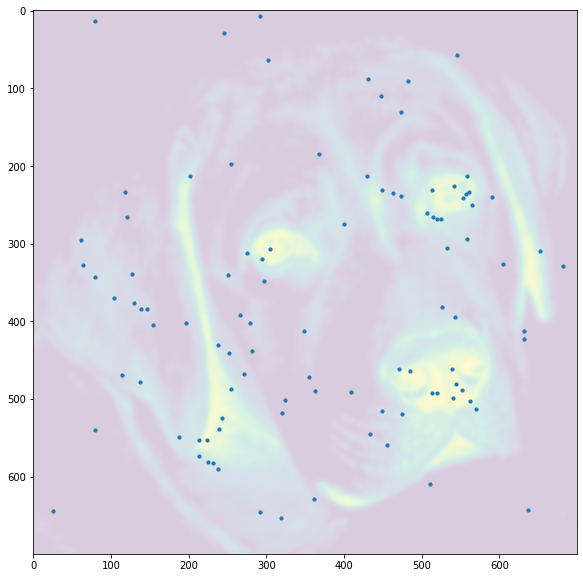

In [127]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(trajectories[:, :, 0], trajectories[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()